---
title: Predicting Strain Phenotype
author: Benjamin Doran
date: Dec 2023
---

In [124]:
#| code-summary: julia setup
#| code-fold: true
using DrWatson
@quickactivate projectdir()

using SpectralInference
using NewickTree
using MLJ
using MLJBase: train_test_pairs
using Distances, Clustering
using Muon, CSV, DataFrames
using Gotree_jll
using Random: seed!
using FreqTables
using NearestNeighbors
using HypothesisTests
using MultipleTesting: adjust, Bonferroni, BenjaminiHochberg
using StatsPlots, StatsBase
theme(:default, grid=false, label="")
include(srcdir("helpers.jl"))

ddir = datadir("exp_raw", "BB669")
rdir = projectdir("_research", "metabolite_SLE_Lasso_model_outofbag") |> mkpath
pdir = plotsdir("metabolite_SLE_Lasso_model_outofbag") |> mkpath
supptbl_dir = projectdir("_research", "SuppTables") |> mkpath

speciescolordf = CSV.read(datadir("exp_raw","BB669","subsettreecolors.csv"), DataFrame)
species_color_dict = Dict(k=>v for (k,v) in zip(speciescolordf.species_name, speciescolordf.color));

In [52]:
@load LassoRegressor pkg=MLJLinearModels verbosity=0
@load OneHotEncoder pkg=MLJModels verbosity=0;

In [18]:
uniprot = readh5ad(datadir("exp_raw", "UP7047", "2020_02_UP7047.h5ad"))
biobank = readh5mu(joinpath(ddir, "BB669.h5mu"))
biobank.obs.kept_species .= biobank.obs.kept_species .== 1
mtx = biobank["UPorder_oggs"].X[:,:];
upsvd = svd(uniprot.X[:, :])
bbusv = SVD(projectinLSV(mtx, upsvd), upsvd.S, upsvd.Vt);

┌ Warning: Cannot join columns with the same name because var_names are intersecting.
└ @ Muon /Users/bend/.julia/packages/Muon/eLqpV/src/mudata.jl:351


In [30]:
# 356 species with >= 20 strain replicates
full_train_mask = biobank.obs.kept_species;

In [33]:
trnYdf = biobank.obs[full_train_mask, :];

In [31]:
# spectral distances are invariant fold partitions 
# because everything is being projected into UniProt latent space
# so precompute them...
UPfullPCs = bbusv.U[full_train_mask, :] * Diagonal(bbusv.S[:]);
partitions = getintervals(bbusv.S, alpha=1.5, q=.75);
Dij = spectraldistances(bbusv.U, bbusv.S, partitions); # 669 full CSB
subsetDij = Dij[full_train_mask, full_train_mask]; # 356 strain replicate CSB

In [95]:
# get metabolite data
metabolite_names_full = replace.(biobank["metabolites_foldchange"].var_names, "_rel"=>"");
bb_met_lfc = biobank["metabolites_foldchange"].X[:, :];
bb_met_lfc[isinf.(bb_met_lfc)] .= 0.0;
metabolicdistance = pairwise(Euclidean(), bb_met_lfc; dims=1);

# filter to metaboltes with at least 10% measureable data
measurable_metabolites_mask = mapslices(c->mean(c .==0.) < .9, bb_met_lfc[full_train_mask, :], dims=1)|>vec;
keepmetabolites_mask = measurable_metabolites_mask;
metabolite_names = metabolite_names_full[keepmetabolites_mask];
metabolite_label = biobank["metabolites_foldchange"].var.label[keepmetabolites_mask]

# subset to 356 sample dataset
metab_trnY = bb_met_lfc[full_train_mask, keepmetabolites_mask];

In [62]:
#| code-summary: get out-of-bag strains for later consortia predictions
#| code-fold: true

unique_condf = CSV.read(datadir("exp_raw", "BBConsortia", "needisolate_oggs.csv"), DataFrame);
unique_condf[13, :seq_id] = "220207-DFI.5.75"
unique_condf[19, :seq_id] = "210820-DFI.7.37A"
unique_condf
seqidtomskid = Dict(k=>v for (k,v) in zip(unique_condf.seq_id, unique_condf.msk_id));

known_added_isolates = filter(:need_oggs => !, unique_condf).msk_id
outofbag_inBB669_mskids = known_added_isolates[isnothing.(indexin(known_added_isolates, trnYdf.Strain_ID))]
outofbag_newBB_mskids = filter(:need_oggs=>identity, unique_condf).msk_id

oob_ogg_counts = CSV.read(datadir("exp_raw","BBConsortia","oggs_for_new_isolates.csv"), DataFrame) |>
    df -> DataFrames.insertcols(df, :value=>1) |>
    df -> DataFrames.transform(df, :COG => (x->replace.(x, "@2"=>"")) => identity) |>
    df -> unstack(df, :seq_id, :COG, :value, combine=sum, fill=0)
insertcols!(oob_ogg_counts, 1, :msk_id=>getindex.(Ref(seqidtomskid), oob_ogg_counts.seq_id))
oob_ogg_counts = oob_ogg_counts[indexin(outofbag_newBB_mskids, oob_ogg_counts.msk_id), :]

outofbag_Uhat_inBB669 = bbusv.U[indexin(outofbag_inBB669_mskids, biobank.obs.Strain_ID),:]
outofbag_PCs_inBB669 = outofbag_Uhat_inBB669 * diagm(bbusv.S[:])

oob_ogg_counts_bborder = vcat(
    biobank["oggs"].X[:,:][indexin(outofbag_inBB669_mskids, biobank.obs.Strain_ID), ogg_mask],
    match_column_order(
        Matrix(oob_ogg_counts[:, 3:end]),
        names(oob_ogg_counts[:, 3:end]),
        biobank["oggs"].var_names[ogg_mask],
    ),
)

oob_ogg_counts_uporder = match_column_order(
    Matrix(oob_ogg_counts[:, 3:end]),
    names(oob_ogg_counts[:, 3:end]),
    biobank["UPorder_oggs"].var_names,
)
outofbag_Uhat_newBB = projectinLSV(float.(oob_ogg_counts_uporder), bbusv) 
outofbag_PCs_newBB = outofbag_Uhat_newBB * diagm(bbusv.S)

outofbag_PCs = vcat(outofbag_PCs_inBB669, outofbag_PCs_newBB)
outofbag_mskids = vcat(outofbag_inBB669_mskids, outofbag_newBB_mskids);

oob_Dij = spectraldistances(
    vcat(bbusv.U[full_train_mask, :], outofbag_Uhat_inBB669, outofbag_Uhat_newBB),
    bbusv.S,
    partitions,
)
subset_oob_Dij = oob_Dij[size(trnYdf,1)+1:end, 1:size(trnYdf, 1)];

## Training a LASSO model

In [96]:
#| code-summary: train lasso model for each resample on each metabolite and save results using SLE encoding
#| code-fold: false

# Takes 1 min
K = 1 # Make predictions with SPI-LASSO on 1 nearest neighbor
λ = 1e-3
REPS = 5
NFOLDS = 4

seed!(424242)
cv = StratifiedCV(nfolds=NFOLDS, shuffle=true);
folds = vcat([train_test_pairs(cv, 1:sum(full_train_mask), trnYdf.Species) for i in 1:REPS]...)


mdl = MLJLinearModels.LassoRegressor(lambda=λ)


oob_preds_df_stacked = DataFrame()
oof_preds_df_stacked = DataFrame()
inf_preds_df_stacked = DataFrame()
coefdf = DataFrame()
for (i, (fold_trn, fold_tst)) in collect(enumerate(folds))
# (i, (fold_trn, fold_tst)) = (1, folds[1])
# (i, (fold_trn, fold_tst)) = (2, folds[2])

    # Use tree to get lineage traces for each training and test sample
    # using projections of taxa into UniProt so these loadings are constant regardless of folds
    foldPCs = UPfullPCs[fold_trn,:]
    trn_nns = map(r->partialsortperm(r, 1:K), eachrow(subsetDij[fold_trn, fold_trn]))
    tst_nns = map(r->partialsortperm(r, 1:K), eachrow(subsetDij[fold_tst, fold_trn]))
    oob_nns = map(r->partialsortperm(r, 1:K), eachrow(subset_oob_Dij[:, fold_trn]))

    # UPGMA tree building...
    foldhc = UPGMA_tree(subsetDij[fold_trn, fold_trn])
    foldtree = readnw(SpectralInference.newickstring(foldhc, trnYdf.Strain_ID[fold_trn]))
    # ladderize!(foldtree, rev=false)
    
    # Make SLE ancester encoding
    trnXdf_all = map(prewalk(foldtree)) do node
        tmp = zeros(length(fold_trn))
        tmp[indexin(getleafnames(node), trnYdf.Strain_ID[fold_trn])] .= 1
        "node__$(id(node))" => tmp
    end |> DataFrame;
    isinternal_fold = map(!isleaf, prewalk(foldtree));
    # reorder nodes by tree depth
    treedists = mapinternalnodes(foldtree) do node
        network_distance(foldtree, node)
    end
    trnXdf = trnXdf_all[:, isinternal_fold];
    trnXdf = trnXdf[:, sortperm(treedists)];
    rename!(trnXdf, ["node__$i" for i in 1:size(trnXdf, 2)])
    
    # Get features for each out-of-fold isolate
    tstXdf = map(tst_nns) do nn
        trnXdf[nn, :] |>
        df -> combine(df, [c => mean for c in 1:size(df, 2)])
    end |> x->vcat(x...)

    # Get features for each out-of-bag isolate
    oobXdf = map(oob_nns) do nn
        trnXdf[nn, :] |>
        df -> combine(df, [c => mean for c in 1:size(df, 2)])
    end |> x->vcat(x...)

    # fit lasso model
    individual_metabolite_results = []
    for (target_idx, (target, mlabel)) in enumerate(zip(metabolite_names, metabolite_label))
        # train model on metabolite feature
        mach = machine(mdl, trnXdf, metab_trnY[fold_trn, target_idx])
        Base.with_logger(Base.NullLogger()) do
            fit!(mach, verbosity=0)
        end
        
        # save results of trained model
        # in fold predictions
        inf_preds_df_stacked = vcat(inf_preds_df_stacked, DataFrame(
            :row_id => fold_trn,
            :metabolite_name => target,
            :metabolite_label => mlabel,
            :fold => ((i-1)%NFOLDS)+1,
            :resample => ((i-1)÷NFOLDS)+1,
            :truth => metab_trnY[fold_trn, target_idx],
            :preds => MLJ.predict(mach, trnXdf),
        ))

        # out-of-fold predictions
        oof_preds_df_stacked = vcat(oof_preds_df_stacked, DataFrame(
            :row_id => fold_tst,
            :msk_id => trnYdf.Strain_ID[fold_tst],
            :metabolite_name => target,
            :metabolite_label => mlabel,
            :fold => ((i-1)%NFOLDS)+1 ,
            :resample => ((i-1)÷NFOLDS)+1 ,
            :truth => metab_trnY[fold_tst, target_idx],
            :preds => MLJ.predict(mach, tstXdf),
        ))

        # out-of-bag predictions used for consortia predictions
        oob_preds_df_stacked = vcat(oob_preds_df_stacked, DataFrame(
            :msk_id => outofbag_mskids,
            :metabolite_name => target,
            :metabolite_label => mlabel,
            :fold => ((i-1)%NFOLDS)+1 ,
            :resample => ((i-1)÷NFOLDS)+1 ,
            # don't know truth # :truth => metab_trnY[fold_tst, target_idx],
            :preds => MLJ.predict(mach, oobXdf),
        ))

        # coefs of model
        coefdf = vcat(coefdf, stack(DataFrame(fitted_params(mach).coefs)) |>
            df -> begin df[!, :treedist] .= sort(treedists); df end |>
            df-> DataFrames.select(df,
                :value => ByRow(x->target) => :metabolite_name,
                :value => ByRow(x->i) => :fold,
                :variable => (x->split.(x, "__")) => [:treedepth, :class],
                :variable => :node_id,
                :value => :coef,
                :treedist,
            )
        )
    end;
    println("on $(i)th resample")
end

CSV.write(joinpath(rdir, "oof_predictions_stacked_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), oof_preds_df_stacked)
CSV.write(joinpath(rdir, "oob_predictions_stacked_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), oob_preds_df_stacked)
CSV.write(joinpath(rdir, "infold_predictions_stacked_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), inf_preds_df_stacked)
CSV.write(joinpath(rdir, "coefs_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), coefdf)

on 1th resample


on 2th resample


on 3th resample


on 4th resample


on 5th resample


on 6th resample


on 7th resample


on 8th resample


on 9th resample


on 10th resample


on 11th resample


on 12th resample


on 13th resample


on 14th resample


on 15th resample


on 16th resample


on 17th resample


on 18th resample


on 19th resample


on 20th resample


"/Users/bend/projects/Doran_etal_2023/_research/metabolite_SLE_Lasso_model_outofbag/coefs_SPItreeLASSO_ancestralencoding_lambda=0.001.csv"

## Training a LASSO model on 3 & 10 PCs for comparison

In [97]:
#| code-summary: train lasso model for each resample on each metabolite and save results using top 3 PCs
#| code-fold: false

# Takes 1 min
K = 1 # Make predictions with SPI-LASSO on 1 nearest neighbor
λ = 1e-3 # regularization coef
R = 3 # Number of PCs to use for training
REPS = 5
NFOLDS = 4

seed!(424242)
cv = StratifiedCV(nfolds=NFOLDS, shuffle=true);
folds = vcat([train_test_pairs(cv, 1:sum(full_train_mask), trnYdf.Species) for i in 1:REPS]...)

Xdf = DataFrame(float.(bbmtx_trn), biobank["oggs"].var_names[ogg_mask])
mdl = MLJLinearModels.LassoRegressor(lambda=λ)


oob_preds_df_stacked_top3 = DataFrame()
oof_preds_df_stacked_top3 = DataFrame()
inf_preds_df_stacked_top3 = DataFrame()
coefdf_top3 = DataFrame()
for (i, (fold_trn, fold_tst)) in collect(enumerate(folds))
# (i, (fold_trn, fold_tst)) = (1, folds[1])
# (i, (fold_trn, fold_tst)) = (2, folds[2])

    Xmtx_fold_trn = Matrix(Xdf[fold_trn, :])
    Xmtx_fold_tst = Matrix(Xdf[fold_tst, :])

    # redo svd for each fold
    foldusv = svd(Xmtx_fold_trn);
    PCs_foldtrn = foldusv.U * diagm(foldusv.S)
    trnXdf = DataFrame(PCs_foldtrn[:, 1:R], ["PC_$r" for r in 1:R])
    tstXdf = DataFrame((projectinLSV(Xmtx_fold_tst, foldusv) * diagm(foldusv.S))[:, 1:R],["PC_$r" for r in 1:R])
    oobXdf = DataFrame((projectinLSV(oob_ogg_counts_bborder, foldusv) * diagm(foldusv.S))[:, 1:R],["PC_$r" for r in 1:R])

    # fit lasso model
    individual_metabolite_results = []
    for (target_idx, (target, mlabel)) in enumerate(zip(metabolite_names, metabolite_label))
        # train model on metabolite feature
        mach = machine(mdl, trnXdf, metab_trnY[fold_trn, target_idx])
        Base.with_logger(Base.NullLogger()) do
            fit!(mach, verbosity=0)
        end
        
        # save results of trained model
        # in fold predictions
        inf_preds_df_stacked_top3 = vcat(inf_preds_df_stacked_top3, DataFrame(
            :row_id => fold_trn,
            :metabolite_name => target,
            :metabolite_label => mlabel,
            :fold => ((i-1)%NFOLDS)+1,
            :resample => ((i-1)÷NFOLDS)+1,
            :truth => metab_trnY[fold_trn, target_idx],
            :preds => MLJ.predict(mach, trnXdf),
        ))

        # out-of-fold predictions
        oof_preds_df_stacked_top3 = vcat(oof_preds_df_stacked_top3, DataFrame(
            :row_id => fold_tst,
            :msk_id => trnYdf.Strain_ID[fold_tst],
            :metabolite_name => target,
            :metabolite_label => mlabel,
            :fold => ((i-1)%NFOLDS)+1 ,
            :resample => ((i-1)÷NFOLDS)+1 ,
            :truth => metab_trnY[fold_tst, target_idx],
            :preds => MLJ.predict(mach, tstXdf),
        ))

        # out-of-bag predictions used for consortia predictions
        oob_preds_df_stacked_top3 = vcat(oob_preds_df_stacked_top3, DataFrame(
            :msk_id => outofbag_mskids,
            :metabolite_name => target,
            :metabolite_label => mlabel,
            :fold => ((i-1)%NFOLDS)+1 ,
            :resample => ((i-1)÷NFOLDS)+1 ,
            # don't know truth # :truth => metab_trnY[fold_tst, target_idx],
            :preds => MLJ.predict(mach, oobXdf),
        ))

        # coefs of model
        coefdf_top3 = vcat(coefdf_top3, stack(DataFrame(fitted_params(mach).coefs)) |>
            df-> DataFrames.select(df,
                :value => ByRow(x->target) => :metabolite_name,
                :value => ByRow(x->i) => :fold,
                :variable => :ogg,
                :value => :coef,
            )
        )
    end;
    println("on $(i)th resample")
end

CSV.write(joinpath(rdir, "oob_predictions_stacked_top3PCs_lambda=$(λ).csv"), oob_preds_df_stacked_top3)
CSV.write(joinpath(rdir, "oof_predictions_stacked_top3PCs_lambda=$(λ).csv"), oof_preds_df_stacked_top3)
CSV.write(joinpath(rdir, "infold_predictions_stacked_top3PCs_lambda=$(λ).csv"), inf_preds_df_stacked_top3)
CSV.write(joinpath(rdir, "coefs_top3PCs_lambda=$(λ).csv"), coefdf_top3)

on 1th resample


on 2th resample


on 3th resample


on 4th resample


on 5th resample


on 6th resample


on 7th resample


on 8th resample


on 9th resample


on 10th resample


on 11th resample


on 12th resample


on 13th resample


on 14th resample


on 15th resample


on 16th resample


on 17th resample


on 18th resample


on 19th resample


on 20th resample


"/Users/bend/projects/Doran_etal_2023/_research/metabolite_SLE_Lasso_model_outofbag/coefs_top3PCs_lambda=0.001.csv"

In [98]:
#| code-summary: train lasso model for each resample on each metabolite and save results using top 10 PCs
#| code-fold: false

# Takes 1 min
K = 1 # Make predictions with SPI-LASSO on 1 nearest neighbor
λ = 1e-3 # regularization coef
R = 10 # Number of PCs to use for training
REPS = 5
NFOLDS = 4

seed!(424242)
cv = StratifiedCV(nfolds=NFOLDS, shuffle=true);
folds = vcat([train_test_pairs(cv, 1:sum(full_train_mask), trnYdf.Species) for i in 1:REPS]...)

Xdf = DataFrame(float.(bbmtx_trn), biobank["oggs"].var_names[ogg_mask])
mdl = MLJLinearModels.LassoRegressor(lambda=λ)


oob_preds_df_stacked_top10 = DataFrame()
oof_preds_df_stacked_top10 = DataFrame()
inf_preds_df_stacked_top10 = DataFrame()
coefdf_top10 = DataFrame()
for (i, (fold_trn, fold_tst)) in collect(enumerate(folds))
# (i, (fold_trn, fold_tst)) = (1, folds[1])
# (i, (fold_trn, fold_tst)) = (2, folds[2])

    Xmtx_fold_trn = Matrix(Xdf[fold_trn, :])
    Xmtx_fold_tst = Matrix(Xdf[fold_tst, :])

    # redo svd for each fold
    foldusv = svd(Xmtx_fold_trn);
    PCs_foldtrn = foldusv.U * diagm(foldusv.S)
    trnXdf = DataFrame(PCs_foldtrn[:, 1:R], ["PC_$r" for r in 1:R])
    tstXdf = DataFrame((projectinLSV(Xmtx_fold_tst, foldusv) * diagm(foldusv.S))[:, 1:R],["PC_$r" for r in 1:R])
    oobXdf = DataFrame((projectinLSV(oob_ogg_counts_bborder, foldusv) * diagm(foldusv.S))[:, 1:R],["PC_$r" for r in 1:R])

    # fit lasso model
    individual_metabolite_results = []
    for (target_idx, (target, mlabel)) in enumerate(zip(metabolite_names, metabolite_label))
        # train model on metabolite feature
        mach = machine(mdl, trnXdf, metab_trnY[fold_trn, target_idx])
        Base.with_logger(Base.NullLogger()) do
            fit!(mach, verbosity=0)
        end
        
        # save results of trained model
        # in fold predictions
        inf_preds_df_stacked_top10 = vcat(inf_preds_df_stacked_top10, DataFrame(
            :row_id => fold_trn,
            :metabolite_name => target,
            :metabolite_label => mlabel,
            :fold => ((i-1)%NFOLDS)+1,
            :resample => ((i-1)÷NFOLDS)+1,
            :truth => metab_trnY[fold_trn, target_idx],
            :preds => MLJ.predict(mach, trnXdf),
        ))

        # out-of-fold predictions
        oof_preds_df_stacked_top10 = vcat(oof_preds_df_stacked_top10, DataFrame(
            :row_id => fold_tst,
            :msk_id => trnYdf.Strain_ID[fold_tst],
            :metabolite_name => target,
            :metabolite_label => mlabel,
            :fold => ((i-1)%NFOLDS)+1 ,
            :resample => ((i-1)÷NFOLDS)+1 ,
            :truth => metab_trnY[fold_tst, target_idx],
            :preds => MLJ.predict(mach, tstXdf),
        ))

        # out-of-bag predictions used for consortia predictions
        oob_preds_df_stacked_top10 = vcat(oob_preds_df_stacked_top10, DataFrame(
            :msk_id => outofbag_mskids,
            :metabolite_name => target,
            :metabolite_label => mlabel,
            :fold => ((i-1)%NFOLDS)+1 ,
            :resample => ((i-1)÷NFOLDS)+1 ,
            # don't know truth # :truth => metab_trnY[fold_tst, target_idx],
            :preds => MLJ.predict(mach, oobXdf),
        ))

        # coefs of model
        coefdf_top10 = vcat(coefdf_top10, stack(DataFrame(fitted_params(mach).coefs)) |>
            df-> DataFrames.select(df,
                :value => ByRow(x->target) => :metabolite_name,
                :value => ByRow(x->i) => :fold,
                :variable => :ogg,
                :value => :coef,
            )
        )
    end;
    println("on $(i)th resample")
end

CSV.write(joinpath(rdir, "oob_predictions_stacked_top10PCs_lambda=$(λ).csv"), oob_preds_df_stacked_top10)
CSV.write(joinpath(rdir, "oof_predictions_stacked_top10PCs_lambda=$(λ).csv"), oof_preds_df_stacked_top10)
CSV.write(joinpath(rdir, "infold_predictions_stacked_top10PCs_lambda=$(λ).csv"), inf_preds_df_stacked_top10)
CSV.write(joinpath(rdir, "coefs_top10PCs_lambda=$(λ).csv"), coefdf_top10)

on 1th resample


on 2th resample


on 3th resample


on 4th resample


on 5th resample


on 6th resample


on 7th resample


on 8th resample


on 9th resample


on 10th resample


on 11th resample


on 12th resample


on 13th resample


on 14th resample


on 15th resample


on 16th resample


on 17th resample


on 18th resample


on 19th resample


on 20th resample


"/Users/bend/projects/Doran_etal_2023/_research/metabolite_SLE_Lasso_model_outofbag/coefs_top10PCs_lambda=0.001.csv"

## Comparison of models

In [70]:
# rdir = projectdir("_research", "metabolite_SLE_Lasso_model") |> mkpath
λ = 1e-3
REPS = 5
NFOLDS = 4

oof_preds_df_stacked = CSV.read(joinpath(rdir, "oof_predictions_stacked_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), DataFrame)
coefdf = CSV.read(joinpath(rdir, "coefs_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), DataFrame);

oof_preds_df_stacked_top3 = CSV.read(joinpath(rdir, "oof_predictions_stacked_top3PCs_lambda=$(λ).csv"), DataFrame)
coefdf_top3 = CSV.read(joinpath(rdir, "coefs_top3PCs_lambda=$(λ).csv"), DataFrame);

oof_preds_df_stacked_top10 = CSV.read(joinpath(rdir, "oof_predictions_stacked_top10PCs_lambda=$(λ).csv"), DataFrame)
coefdf_top10 = CSV.read(joinpath(rdir, "coefs_top10PCs_lambda=$(λ).csv"), DataFrame);

In [99]:
oof_preds_df_stacked

56960×8 DataFrame
   Row │ row_id  msk_id      metabolite_name  metabolite_label  fold   resampl ⋯
       │ Int64   String      String           String            Int64  Int64   ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │    342  MSK.19.38   Acetate          Acetate               1          ⋯
     2 │     90  MSK.22.14   Acetate          Acetate               1
     3 │    121  MSK.22.19   Acetate          Acetate               1
     4 │    223  MSK.18.5    Acetate          Acetate               1
     5 │    163  MSK.19.91   Acetate          Acetate               1          ⋯
     6 │    285  MSK.17.63   Acetate          Acetate               1
     7 │     82  MSK.19.93   Acetate          Acetate               1
     8 │    133  DFI.1.38    Acetate          Acetate               1
   ⋮   │   ⋮         ⋮              ⋮                ⋮            ⋮       ⋮    ⋱
 56954 │    170  MSK.17.56   Valine           Valine                4          ⋯
 56955 │    264  MSK.22.64   Valine           Valine                4
 56956 │     24  MSK.11.50   Valine           Valine                4
 56957 │    106  MSK.15.52   Valine           Valine                4
 56958 │    148  MSK.23.42   Valine           Valine                4          ⋯
 56959 │    345  MSK.20.44   Valine           Valine                4
 56960 │    294  MSK.23.63   Valine           Valine                4
                                                3 columns and 56945 rows omitted

In [106]:
slelassopltdf = oof_preds_df_stacked |>
    df -> rename(df, :preds => :preds_SLE) |>
    df -> select(df, [:row_id, :metabolite_label, :fold, :resample, :truth, :preds_SLE]) |>
    df -> groupby(df, [:metabolite_label, :fold, :resample]) |>
    df -> combine(df,
        [:preds_SLE, :truth] => ((yhat, y)->rsquared(yhat,y)) => :rsquared_SLE, 
    ) |>
    df -> groupby(df, [:metabolite_label]) |>
    df -> DataFrames.transform(df, 
        :rsquared_SLE => mean,
    ) |>
    df -> stack(df, :rsquared_SLE) |>
    df -> sort(df, [:metabolite_label, :resample, :fold]) |>
    df -> rename(df, :variable => :measure_model, :value => :rsquared)
CSV.write(joinpath(supptbl_dir, "Supplementary_Table_6A.tsv"), slelassopltdf, delim="\t")

slelassopltdf |>
    df -> groupby(df, :metabolite_label) |>
    df -> combine(df, :rsquared => mean)
CSV.write(joinpath(supptbl_dir, "Supplementary_Table_6B.tsv"), slelassopltdf, delim="\t");

### R squared plots

In [107]:
slelassopltdf = oof_preds_df_stacked |>
    df -> rename(df, :preds => :preds_SLE) |>
    df -> select(df, [:row_id, :metabolite_label, :fold, :resample, :truth, :preds_SLE]) |>
    df -> groupby(df, [:metabolite_label, :fold, :resample]) |>
    df -> combine(df,
        [:preds_SLE, :truth] => ((yhat, y)->rsquared(yhat,y)) => :rsquared_SLE, 
    ) |>
    df -> groupby(df, [:metabolite_label]) |>
    df -> DataFrames.transform(df, 
        :rsquared_SLE => mean,
        [:fold, :resample] => ((x, y) -> x.*y) => :fold_iter,
    ) |>
    df -> stack(df, :rsquared_SLE) |>
    df -> sort(df, [:metabolite_label, :fold_iter])

top3lassopltdf = oof_preds_df_stacked_top3 |>
    df -> rename(df, :preds => :preds_top3) |>
    df -> select(df, [:row_id, :metabolite_label, :fold, :resample, :truth, :preds_top3]) |>
    df -> groupby(df, [:metabolite_label, :fold, :resample]) |>
    df -> combine(df,
        [:preds_top3, :truth] => ((yhat, y)->rsquared(yhat,y)) => :rsquared_top3, 
    ) |>
    df -> groupby(df, [:metabolite_label]) |>
    df -> DataFrames.transform(df, 
        :rsquared_top3 => mean,
        [:fold, :resample] => ((x, y) -> x.*y) => :fold_iter,
    ) |>
    df -> stack(df, :rsquared_top3) |>
    df -> sort(df, [:metabolite_label, :fold_iter]) |>
    df -> insertcols!(df, :rsquared_SLE_mean => slelassopltdf.rsquared_SLE_mean)

insertcols!(slelassopltdf, :rsquared_top3_mean => top3lassopltdf.rsquared_top3_mean)

pltdf_full = vcat(select(slelassopltdf, [:metabolite_label, :rsquared_SLE_mean, :rsquared_top3_mean, :variable, :value]),
             select(top3lassopltdf, [:metabolite_label, :rsquared_SLE_mean, :rsquared_top3_mean, :variable, :value])) |>
    df -> sort(df, :rsquared_SLE_mean)

sigresults = pltdf_full |>
    df -> groupby(df, :metabolite_label) |>
    df -> combine(df,
        :rsquared_SLE_mean => first => :rsquared_SLE_mean,
        :rsquared_top3_mean => first => :rsquared_top3_mean,
        [:variable, :value] => ((grp, rsqval) -> 
            pvalue(UnequalVarianceTTest(rsqval[grp.=="rsquared_SLE"], rsqval[grp.=="rsquared_top3"]), tail=:right)) => :pval
            # pvalue(MannWhitneyUTest(rsqval[grp.=="rsquared_SLE"], rsqval[grp.=="rsquared_top3"]), tail=:right)) => :pval
    ) |>
    df -> DataFrames.transform(df, :pval => (p->adjust(p, Bonferroni())) => :pval_bon) |>
    df -> DataFrames.transform(df, :pval_bon => (p->floor.(Int, log10.(1 ./ p))) => :poweroftest);

predictablemetabolites = filter(
    [:rsquared_SLE_mean, :rsquared_top3_mean, :pval_bon] => 
        (sle_mean, top3_mean, σ) -> sle_mean > 0.5 || top3_mean > 0.5 || σ < 0.05,
    sigresults
);

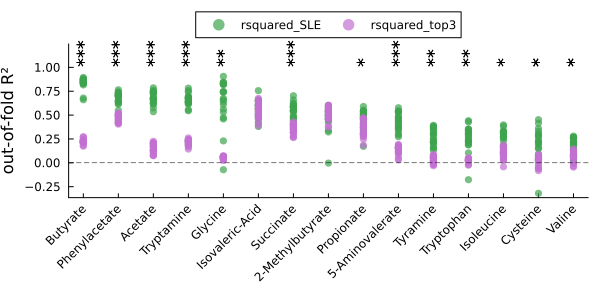

In [121]:
pltdf = filter(:metabolite_label => ∈(predictablemetabolites.metabolite_label), pltdf_full);
plot(
    ylabel="out-of-fold R²",
    bottommargin=12Plots.Measures.mm,
    xrotation=45,
    legend=:outertop,
    legendcolumns=2,
    size=(600, 300),
    xflip=true, 
)
@df pltdf dotplot!(
    string.(round.(:rsquared_SLE_mean, digits=6)), :value,
    group=:variable,
    mode=:none,
    side=[:left :right],
    alpha=.7,
    markerstrokewidth=0,
    xticks=((1:length(unique(:metabolite_label))).-.5, unique(:metabolite_label)),
    ylims=(-Inf, 1.2),
    widen=true,
    # label="Full lasso",
    c=[3 4],
)
hline!([0], c=:black, lw=.5, linestyle=:dash)
@df predictablemetabolites annotate!(
    string.(round.(:rsquared_SLE_mean, digits=6)), 
    ones(nrow(sigresults)) .+ 0.01,
    text.(
        repeat.("*", (:poweroftest .>=10) .+ (:poweroftest .>=5) .+ (:poweroftest .>=1)),
        12, :left, rotation=90
    ),
)

### scatter plots

#### Top 3 PCs plot

In [147]:
top3_explainedvar = map(folds) do (fold_trn, fold_tst)
    Xmtx_fold_trn = Matrix(Xdf[fold_trn, :])
    foldusv = svd(Xmtx_fold_trn)
    ev = explainedvariance(foldusv.S) .* 100
    sum(ev[1:3])
end |> mean;

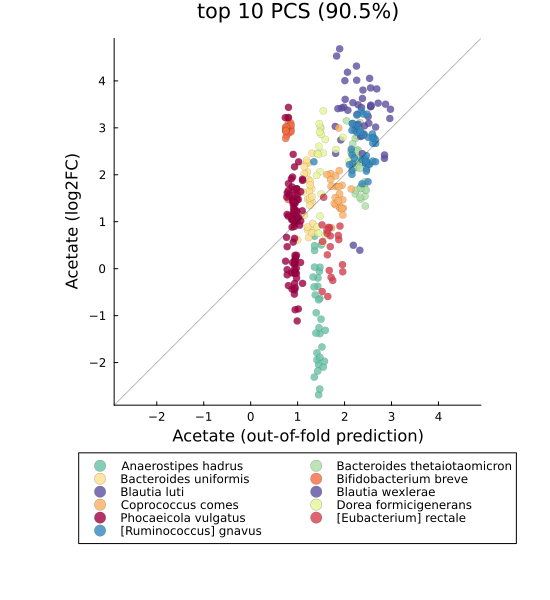

In [149]:

r = 5
predsdf = filter(:metabolite_name => ==(metabolite_name), oof_preds_df_stacked_top3) |>
    df -> filter(:resample => ==(r), df)
speciescolors_ordered = get.(Ref(species_color_dict), trnYdf.Species[predsdf.row_id], :grey)
@df predsdf scatter(
    :preds, :truth,
    group=trnYdf.Species[:row_id],
    c=speciescolors_ordered,
    lims=extrema(vcat(:preds, :truth)),
    widen=true,
    ratio=1,
    size=(550,600),
    legend=:outerbottom,
    legend_column=2,
    markerstrokewidth=.1,
    alpha=.8,
    title="top 10 PCS ($(round(top3_explainedvar, digits=1))%)",
    xlabel="$metabolite_name (out-of-fold prediction)",
    ylabel="$metabolite_name (log2FC)",
)
plot!(identity, -20, 20, c=:black, alpha=.5, lw=0.5)

#### Top 10 PCs plot

In [151]:
top10_explainedvar = map(folds) do (fold_trn, fold_tst)
    Xmtx_fold_trn = Matrix(Xdf[fold_trn, :])
    foldusv = svd(Xmtx_fold_trn)
    ev = explainedvariance(foldusv.S) .* 100
    sum(ev[1:10])
end |> mean;

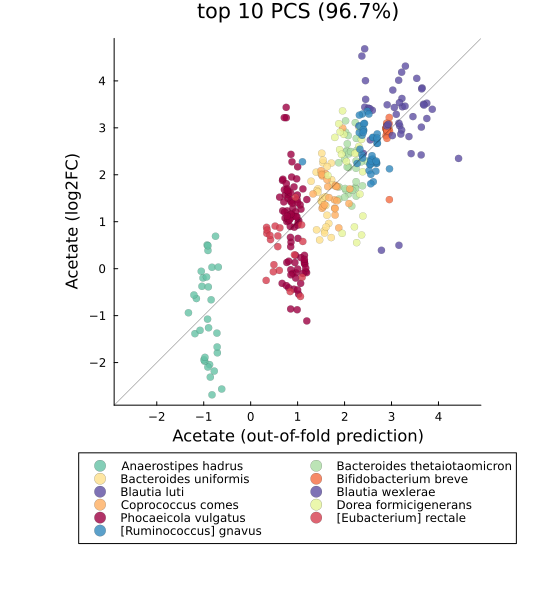

In [152]:
r = 5
predsdf = filter(:metabolite_name => ==(metabolite_name), oof_preds_df_stacked_top10) |>
    df -> filter(:resample => ==(r), df)
speciescolors_ordered = get.(Ref(species_color_dict), trnYdf.Species[predsdf.row_id], :grey)
@df predsdf scatter(
    :preds, :truth,
    group=trnYdf.Species[:row_id],
    c=speciescolors_ordered,
    lims=extrema(vcat(:preds, :truth)),
    widen=true,
    ratio=1,
    size=(550,600),
    legend=:outerbottom,
    legend_column=2,
    markerstrokewidth=.1,
    alpha=.8,
    title="top 10 PCS ($(round(top10_explainedvar, digits=1))%)",
    xlabel="$metabolite_name (out-of-fold prediction)",
    ylabel="$metabolite_name (log2FC)",
)
plot!(identity, -20, 20, c=:black, alpha=.5, lw=0.5)

#### SLE plot

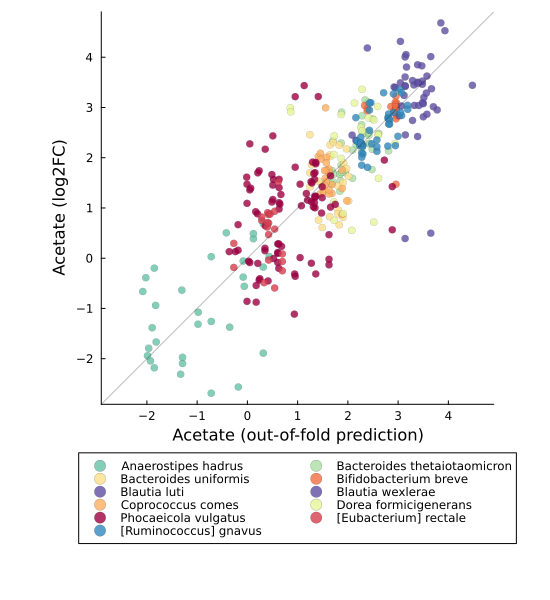

In [ ]:

r = 5
predsdf = filter(:metabolite_name => ==(metabolite_name), oof_preds_df_stacked) |>
    df -> filter(:resample => ==(r), df)
speciescolors_ordered = get.(Ref(species_color_dict), trnYdf.Species[predsdf.row_id], :grey)
@df predsdf scatter(
    :preds, :truth,
    group=trnYdf.Species[:row_id],
    c=speciescolors_ordered,
    lims=extrema(vcat(:preds, :truth)),
    widen=true,
    ratio=1,
    size=(550,600),
    legend=:outerbottom,
    legend_column=2,
    markerstrokewidth=.1,
    alpha=.8,
    xlabel="$metabolite_name (out-of-fold prediction)",
    ylabel="$metabolite_name (log2FC)",
)
plot!(identity, -20, 20, c=:black, alpha=.5, lw=0.5)

## Plot tree and metabolites

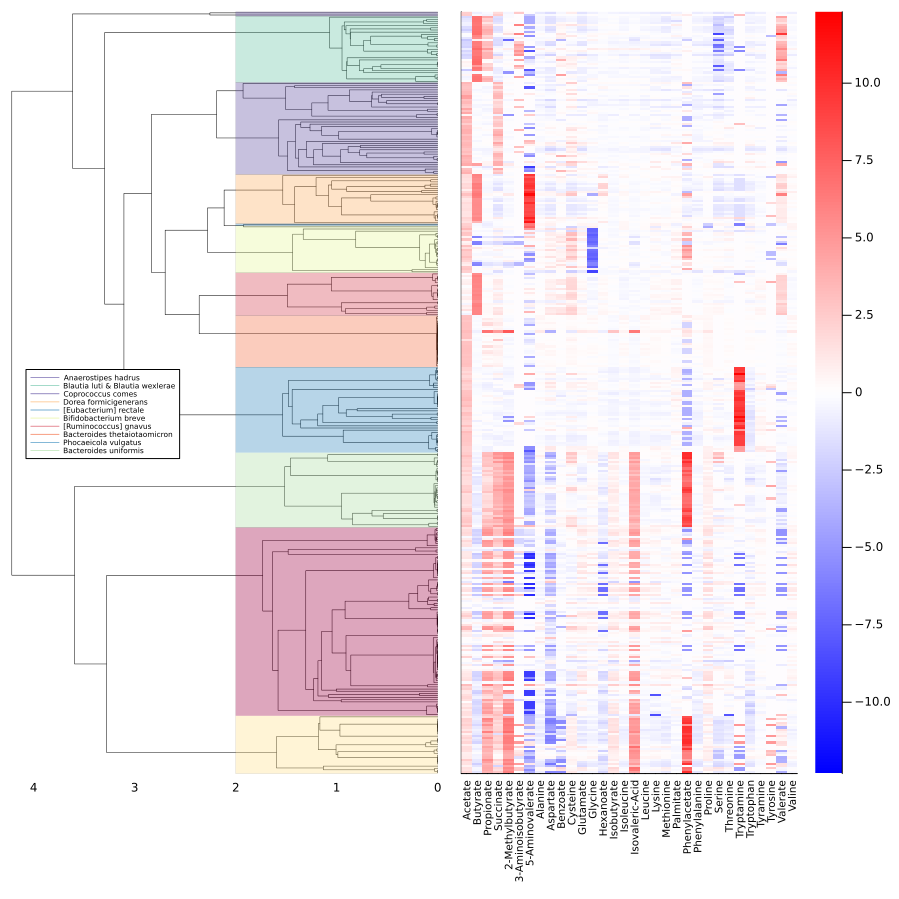

In [211]:
# plot cladogram
strvar_tree_hc = UPGMA_tree(subsetDij ./ size(biobank["UPorder_oggs"], 2))
subsettreestring = SpectralInference.newickstring(strvar_tree_hc, trnYdf.Strain_ID)
subsettree = readnw(subsettreestring);
plot(strvar_tree_hc, 
    # size=(600, 900),
    lw=.5,
    yflip=true, 
    xmirror=true,
    xticks=:none,
    permute=(:y, :x),
    grid=false,
    tickdirection=:none,
    rightmargin=1Plots.Measures.mm, 
    label="",
    framestyle=:grid,
)

# plot annotation rectangles
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
speciesvector = trnYdf.Species[strvar_tree_hc.order]
breaks = findall(speciesvector[begin:(end-1)] .!= speciesvector[2:end])[Not([10, 11, 12, 13, 14,15])]
edges = [(s, e) for (s,e) in zip(vcat([0],breaks), vcat(breaks, [length(speciesvector)]))];
rects = [rectangle(2,(e-s),0,s+.5) for (s,e) in zip(vcat([0],breaks), vcat(breaks, [length(speciesvector)]))];
rectspeciescolors = permutedims(speciescolordf.color[indexin(speciesvector[first.(edges).+1], speciescolordf.species_name)]);
fancy_treeplot = plot!(permutedims(rects), fill=0.35, lw=0, c=rectspeciescolors, label="")

# plot legend for tree
specieslabels= [
    "Bacteroides uniformis",
    "Phocaeicola vulgatus",
    "Bacteroides thetaiotaomicron",
    "[Ruminococcus] gnavus",
    "Bifidobacterium breve",
    "[Eubacterium] rectale",
    "Dorea formicigenerans",
    "Coprococcus comes",
    "Blautia luti & Blautia wexlerae",
    "Anaerostipes hadrus",
]
fancy_treeplot = plot!(zeros(1, 10), 
    legend=:left,
    labels=permutedims(reverse(specieslabels)), 
    c=reverse(rectspeciescolors),
    legendfontsize=5,
);

# plot metabolite heatmap
treeorder = indexin(getleafnames(subsettree), trnYdf.Strain_ID);
hplot = heatmap(metab_trnY[treeorder, :],
    c=:bwr, clims=getlims(metab_trnY),
    xticks=(1:size(metab_trnY,2), metabolite_label),
    xrotation=90, xtickfontsize=7,
    yticks=:none,
);

plot(fancy_treeplot, hplot, size=(900,900))

Zooming in we can look at *A. hadrus*, and its measured Acetate relative concentration and our prediction for those Acetate relative concentration

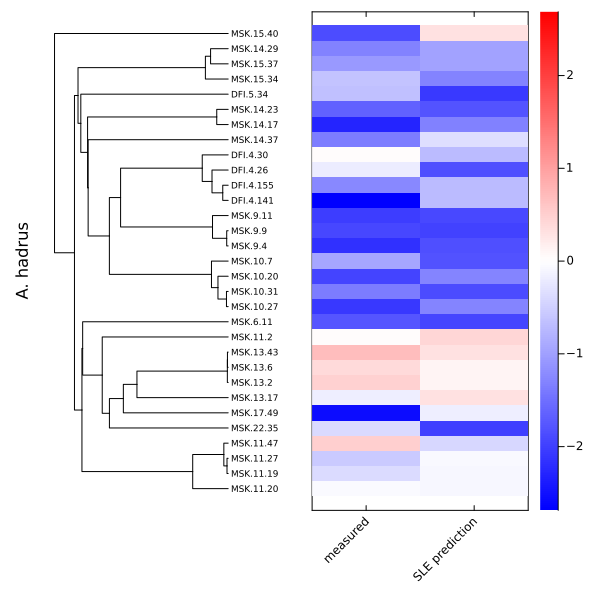

In [212]:
## Plot Hadrus tree with metabolite truth & predictions

# tree data
treeorder = indexin(getleafnames(subsettree), trnYdf.Strain_ID);
hadrusnames = trnYdf.Strain_ID[findall(contains.(trnYdf.Species, "hadrus"))]
hadrus_treeidxs = indexin(hadrusnames, getleafnames(subsettree));
hadrustree = readnw(NewickTree.nwstr(NewickTree.extract(subsettree, hadrusnames)))
hadrusnames = getleafnames(hadrustree)
hadrus_treeidxs = indexin(hadrusnames, getleafnames(subsettree));

# tree plot
tp = plot(hadrustree, fs=6, 
    ylabel="A. hadrus", 
    rightmargin=15Plots.mm, 
    leftmargin=5Plots.mm,
    framestyle=:grid,
    ticks=false,
)

# heatmap data
pltdf = filter(:metabolite_name => ==("Acetate"), oof_preds_df_stacked) |>
    df -> filter(:resample => ==(5), df) |>
    df -> sort(df, :row_id);
hadruspltdf = pltdf[treeorder, :][hadrus_treeidxs, :];
pltmtx = Matrix(hadruspltdf[:, [:truth, :preds]])

# heatmap
hp = heatmap(pltmtx,
    c=:bwr, clims=getlims(pltmtx),
    xticks=(1:2, ["measured", "SLE prediction"]),
    xrotation=45,
    yticks=false,
    framestyle=:box
)

# combined plot
layout = @layout [a{.4w} b]
plot(tp, hp, layout=layout, link=:y, size=(600,600))

## Plot example fold tree

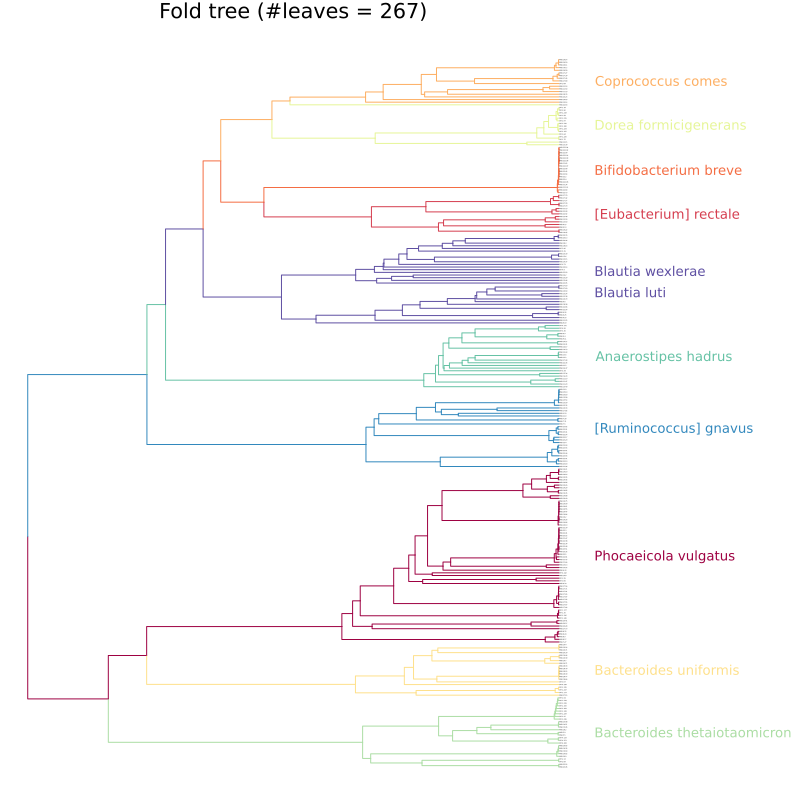

In [244]:
fold_trn = folds[1][1]
folddij = subsetDij[fold_trn, fold_trn] ./ size(biobank["UPorder_oggs"], 2)
foldtree_hc = UPGMA_tree(folddij)
foldtree = readnw(SpectralInference.newickstring(foldtree_hc, trnYdf.Strain_ID[fold_trn]));
ladderize!(foldtree)

branchcolors = map(prewalk(foldtree)) do node
    mskids = name.(getleaves(node))
    species_id = mode(trnYdf.Species[indexin(mskids, trnYdf.Strain_ID)])
    get.(Ref(species_color_dict), species_id, :grey)
end |> vec |> x->x[2:end] |> permutedims

plot(foldtree, 
    linecolor=branchcolors,
    title="Fold tree (#leaves = $(length(getleaves(foldtree))))",
    size=(800,800),
    fs=1,
    rightmargin=5.5Plots.cm,
    framestyle=:grid, ticks=false
)

# species 
speciesvector = trnYdf.Species[fold_trn][indexin(getleafnames(foldtree), trnYdf.Strain_ID[fold_trn])];
for (i, (k,v)) in enumerate(zip(speciescolordf.species_name, speciescolordf.color))
    yval = median(findall(==(k), speciesvector))
    annotate!(4.5, yval, text(k, 9, :left, v))
end
plot!()